# __Sprint 18: Proyecto final__

Al operador de telecomunicaciones  le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

## __1. Preparación y limpieza de datos__

#### __*Inicialización*__

In [1]:
#importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier


In [2]:
#leer datasets
contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

##### *Personal dataset*

In [3]:
#personal_df

In [4]:
personal_df.info()
personal_df['customerID'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


7043

In [5]:
# columnas con categoría
cat_cols = ['gender', 'Partner', 'Dependents']
for i in cat_cols:
    print(personal_df[i].unique())


personal_df[cat_cols] = personal_df[cat_cols].astype('category')

personal_df.info()

['Female' 'Male']
['Yes' 'No']
['No' 'Yes']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     7043 non-null   object  
 1   gender         7043 non-null   category
 2   SeniorCitizen  7043 non-null   int64   
 3   Partner        7043 non-null   category
 4   Dependents     7043 non-null   category
dtypes: category(3), int64(1), object(1)
memory usage: 131.2+ KB


In [6]:
#convertir SeniorCitizen a bool type

personal_df['SeniorCitizen'] = personal_df['SeniorCitizen'].astype(bool)

In [7]:
#personal_df

##### *Internet dataset*

In [8]:
#internet_df

In [9]:
internet_df.info()
internet_df['customerID'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


5517

In [10]:
cat_cols = internet_df.columns.drop('customerID')
for i in cat_cols:
    print(internet_df[i].unique())

    
internet_df[cat_cols] = internet_df[cat_cols].astype('category')

['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


##### *Phone dataset*

In [11]:
#phone_df

In [12]:
phone_df.info()
phone_df['customerID'].duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


0

In [13]:
print(phone_df['MultipleLines'].unique())
phone_df['MultipleLines'] = phone_df['MultipleLines'].astype('category')

['No' 'Yes']


##### *Contract dataset*

In [14]:
#contract_df

In [15]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [16]:
print(contract_df['customerID'].nunique())

7043


In [17]:
#convertir TotalCharges a número
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'].str.strip(), errors='coerce')

In [18]:
#Revisar nulos en total charges
print(contract_df['TotalCharges'].isna().sum())

11


In [19]:
#convertir columnas de fechas a datetime
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'],errors='coerce')
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'],errors='coerce')

In [20]:
contract_df['BeginDate'].isna().sum()
contract_df['EndDate'].isna().sum()

5174

In [21]:
# columna para identificar clientes que ya se fueron
contract_df['churn'] = contract_df['EndDate'].notna()
#contract_df

In [22]:
# columnas con categoría
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod']
for i in cat_cols:
    print(contract_df[i].unique())


contract_df[cat_cols] = contract_df[cat_cols].astype('category')

contract_df.info()

['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   churn             7043 non-null   bool          
dtypes: bool(1), category(3), datetime64[ns](2), float64(2), object(1)
memory usage: 303.2+ KB


In [23]:
# calcular meses de servicio al día de hoy(tenure)
contract_df['tenure_months'] = (
    (pd.Timestamp('2025-07-21') - contract_df['BeginDate']).dt.days // 30
)



In [24]:
# rellenar nulos de 'TotalCharges'
contract_df['TotalCharges'] = contract_df['TotalCharges'].fillna(
    contract_df['MonthlyCharges'] * contract_df['tenure_months']
)

print(contract_df['TotalCharges'].isna().sum())

0


## __2. Análisis exploratorio de datos__

__*Full dataset*__

In [25]:
#unir dataframes
full_df = (contract_df
           .merge(personal_df, on='customerID')
           .merge(internet_df, on='customerID', how='left')
           .merge(phone_df, on='customerID', how='left'))

#full_df

In [26]:
def cancelation_rate(column):
    result = full_df.groupby(column)['churn'].mean().sort_values(ascending=False)
    print(f"\nTasa de cancelación por {column}:\n", result.round(3))

cancelation_rate('Type')
cancelation_rate('PaymentMethod')
cancelation_rate('SeniorCitizen')
cancelation_rate('InternetService')
cancelation_rate('MultipleLines')


Tasa de cancelación por Type:
 Type
Month-to-month    0.427
One year          0.113
Two year          0.028
Name: churn, dtype: float64

Tasa de cancelación por PaymentMethod:
 PaymentMethod
Electronic check             0.453
Mailed check                 0.191
Bank transfer (automatic)    0.167
Credit card (automatic)      0.152
Name: churn, dtype: float64

Tasa de cancelación por SeniorCitizen:
 SeniorCitizen
True     0.417
False    0.236
Name: churn, dtype: float64

Tasa de cancelación por InternetService:
 InternetService
Fiber optic    0.419
DSL            0.190
Name: churn, dtype: float64

Tasa de cancelación por MultipleLines:
 MultipleLines
Yes    0.286
No     0.250
Name: churn, dtype: float64


In [27]:
# columna para número de servicios de internet contratados
servicios = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
full_df['n_internet_services'] = (full_df[servicios] == 'Yes').sum(axis=1)

In [28]:
# ratio totalCharges/tenure_months
full_df['charges_ratio'] = full_df['TotalCharges'] / full_df['tenure_months']

In [29]:
# columnas complementarias: tipo de servicio de internet y cuántos servicios contrata
full_df['DSL_services'] = (full_df['InternetService'] == 'DSL') * full_df['n_internet_services']
full_df['Fiber_services'] = (full_df['InternetService'] == 'Fiber optic') * full_df['n_internet_services']
full_df['NoInternet_services'] = (full_df['InternetService'].isna()) * full_df['n_internet_services']

In [30]:
#full_df.info()

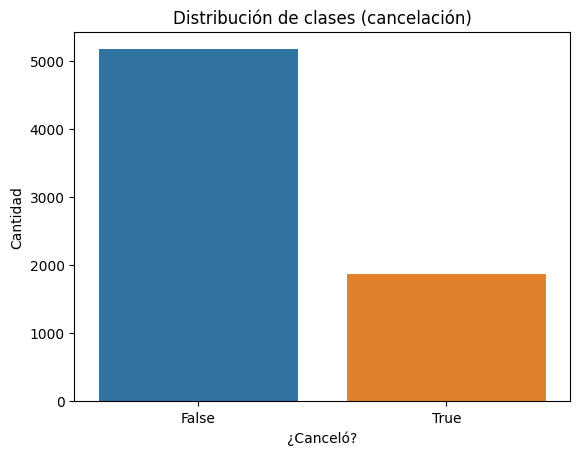

False    0.73463
True     0.26537
Name: churn, dtype: float64


In [31]:
# distribución de churn

sns.countplot(data=full_df, x='churn')
plt.title('Distribución de clases (cancelación)')
plt.xlabel('¿Canceló?')
plt.ylabel('Cantidad')
plt.show()

# Proporción
print(full_df['churn'].value_counts(normalize=True))

La distribución de clases está ligeramente desbalanceada, por lo que se considerará usar 'class_weight=balanced' en los modelos a entrenar, y usar F1 score como métrica principal.

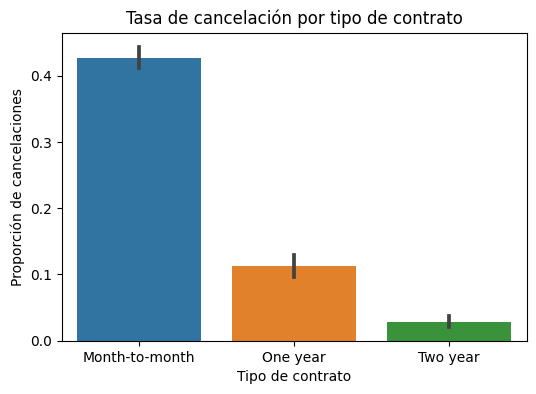

In [32]:
# tasa de cancelación por tipo de contrato

plt.figure(figsize=(6,4))
sns.barplot(data=full_df, x='Type', y='churn')
plt.title('Tasa de cancelación por tipo de contrato')
plt.ylabel('Proporción de cancelaciones')
plt.xlabel('Tipo de contrato')
plt.show()

Los contratos mensuales tienen más cancelaciones

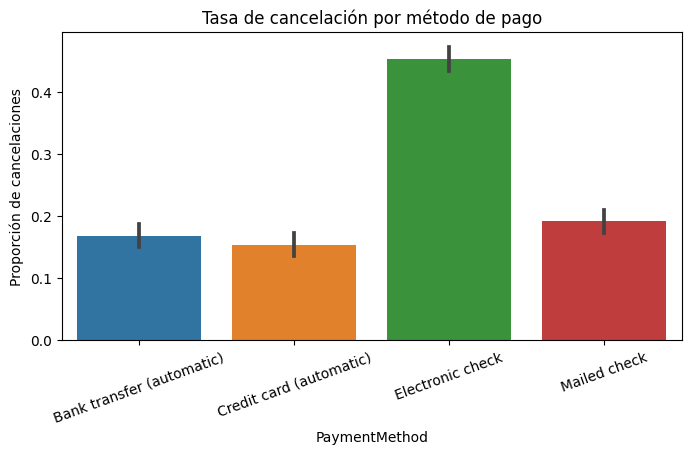

In [33]:
# tasa de cancelación por tipo de pago
plt.figure(figsize=(8,4))
sns.barplot(data=full_df, x='PaymentMethod', y='churn')
plt.title('Tasa de cancelación por método de pago')
plt.xticks(rotation=20)
plt.ylabel('Proporción de cancelaciones')
plt.show()

Los clientes que eligen cheque electrónico como método de pago cancelan más que el resto.

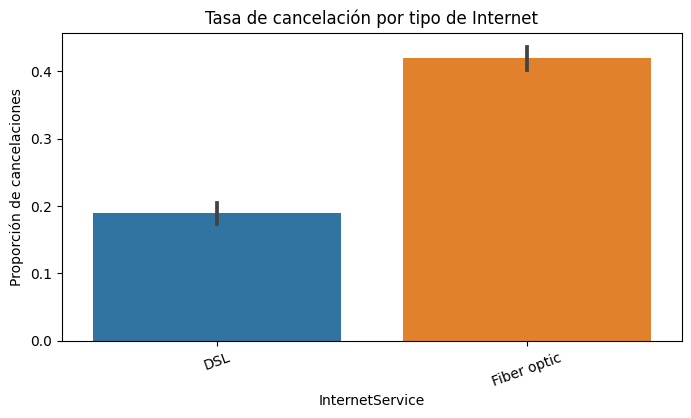

In [34]:
# tasa de cancelación por tipo de pago
plt.figure(figsize=(8,4))
sns.barplot(data=full_df, x='InternetService', y='churn')
plt.title('Tasa de cancelación por tipo de Internet')
plt.xticks(rotation=20)
plt.ylabel('Proporción de cancelaciones')
plt.show()

Clientes con fibra óptica son más propensos a cancelar.

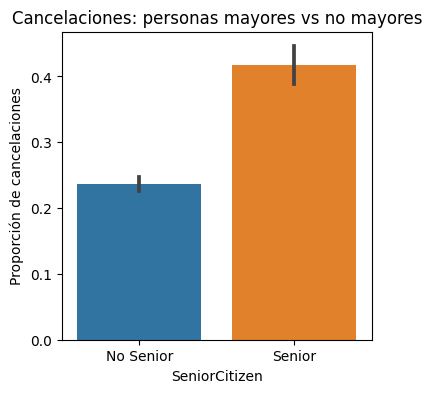

In [35]:
# Cancelación por grupo de edad (senior vs no senior)

plt.figure(figsize=(4,4))
sns.barplot(data=full_df, x='SeniorCitizen', y='churn')
plt.title('Cancelaciones: personas mayores vs no mayores')
plt.xticks([0,1], ['No Senior', 'Senior'])
plt.ylabel('Proporción de cancelaciones')
plt.show()

Los clientes senior cancelan más.

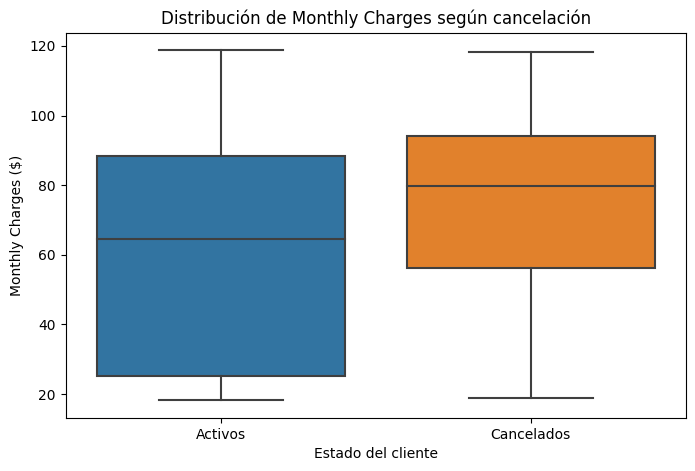

In [36]:
# comparación de distribución de monthly charges entre cancelados y no cancelados
plt.figure(figsize=(8,5))
sns.boxplot(data=full_df, x='churn', y='MonthlyCharges')
plt.title('Distribución de Monthly Charges según cancelación')
plt.xticks([0,1], ['Activos', 'Cancelados'])
plt.ylabel('Monthly Charges ($)')
plt.xlabel('Estado del cliente')
plt.show()

Los cientes con cargos mensuales más altos cancelan en mayor medida.

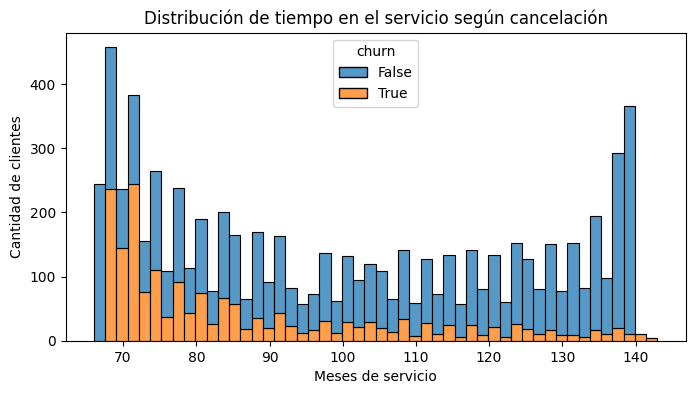

In [37]:
#Relación entre tenure_months y cancelación
plt.figure(figsize=(8,4))
sns.histplot(data=full_df, x='tenure_months', hue='churn', multiple='stack', bins=50)
plt.title('Distribución de tiempo en el servicio según cancelación')
plt.xlabel('Meses de servicio')
plt.ylabel('Cantidad de clientes')
plt.show()

Gran parte de las cancelaciones suelen ser alrededor de 70 meses.

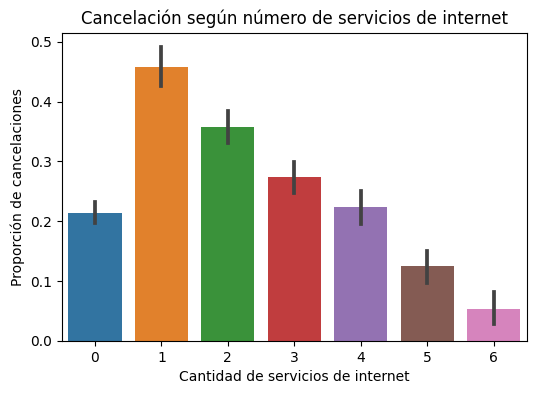

In [38]:
# número de servicios de internet vs cancelación
plt.figure(figsize=(6,4))
sns.barplot(data=full_df, x='n_internet_services', y='churn')
plt.title('Cancelación según número de servicios de internet')
plt.xlabel('Cantidad de servicios de internet')
plt.ylabel('Proporción de cancelaciones')
plt.show()

Se podría sugerir que más servicios contratados retienen mejor a los clientes.

In [39]:
# correlación de variables numéricas con churn
full_df[['MonthlyCharges', 'TotalCharges', 'tenure_months', 'n_internet_services', 'SeniorCitizen', 'churn']].corr()

,MonthlyCharges,TotalCharges,tenure_months,n_internet_services,SeniorCitizen,churn
MonthlyCharges,1.000000,0.650765,0.260700,0.724706,0.220173,0.193356
TotalCharges,0.650765,1.000000,0.826892,0.746136,0.102220,-0.199540
tenure_months,0.260700,0.826892,1.000000,0.497468,0.023656,-0.311935
n_internet_services,0.724706,0.746136,0.497468,1.000000,0.067493,-0.087698
SeniorCitizen,0.220173,0.102220,0.023656,0.067493,1.000000,0.150889
churn,0.193356,-0.199540,-0.311935,-0.087698,0.150889,1.000000


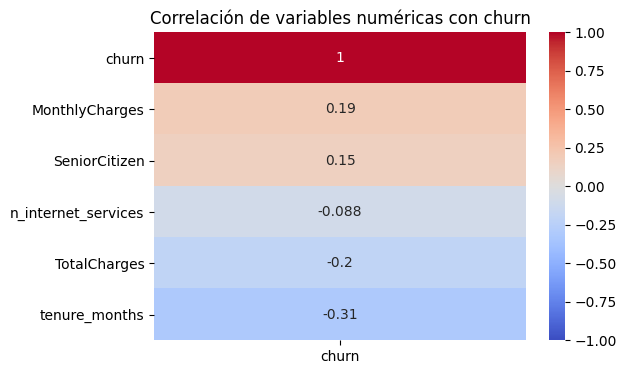

In [40]:
# graficar correlación

num_cols = ['MonthlyCharges', 'TotalCharges', 'tenure_months', 'n_internet_services', 'SeniorCitizen', 'churn']
corr_matrix = full_df[num_cols].corr()

# Mostrar solo la correlación con churn
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix[['churn']].sort_values(by='churn', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación de variables numéricas con churn')
plt.show()

No resulta de gran relevancia pero respalda las observaciones de que: a mayor monthly charge, mayor posibilidad de que cancelen. Y entre más meses de servicio, menor probabilidad de que cancelen.

Parece contradictorio que TotalCharges muestra una correlación negativa en casi la misma proporción que Monthly Charges muestra correlación positiva, pero TotalCharges tiene alta correlación con tenure: clientes con total charges altos tienen mayor historial de pagos.

## __3. Transformación y codificación__

In [41]:
#eliminar columnas innecesarias

cols_to_drop = [
    'customerID', 'BeginDate', 'EndDate',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]


df = full_df.drop(columns=cols_to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Type                 7043 non-null   category
 1   PaperlessBilling     7043 non-null   category
 2   PaymentMethod        7043 non-null   category
 3   MonthlyCharges       7043 non-null   float64 
 4   TotalCharges         7043 non-null   float64 
 5   churn                7043 non-null   bool    
 6   tenure_months        7043 non-null   int64   
 7   gender               7043 non-null   category
 8   SeniorCitizen        7043 non-null   bool    
 9   Partner              7043 non-null   category
 10  Dependents           7043 non-null   category
 11  InternetService      5517 non-null   category
 12  MultipleLines        6361 non-null   category
 13  n_internet_services  7043 non-null   int64   
 14  charges_ratio        7043 non-null   float64 
 15  DSL_services         

In [42]:
# manejar los valores nulos antes de codificar
df['InternetService'] = df['InternetService'].cat.add_categories('No service').fillna('No service')
df['MultipleLines'] = df['MultipleLines'].cat.add_categories('No service').fillna('No service')


#df.info()

In [43]:
df_encoded = pd.get_dummies(df, drop_first=False)

In [44]:
# dividir en entrenamiento y validación usando el parámetro 'stratify' para mantener la proporción de clases
features = df_encoded.drop(columns='churn')
target = df_encoded['churn']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)


In [45]:
# escalado de columnas numéricas
numeric = ['MonthlyCharges', 'TotalCharges', 'tenure_months', 'n_internet_services', 'charges_ratio', 'DSL_services', 'Fiber_services', 'NoInternet_services']

scaler = StandardScaler()

features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])



/tmp/ipykernel_308/1459860229.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.fit_transform(features_train[numeric])
/.venv/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_308/1459860229.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

## __4. Entrenamiento y evaluación de modelos__

#### Modelo dummy

In [46]:
# prueba de cordura
target_pred = np.ones_like(target_valid)
print(classification_report(target_valid, target_pred))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00      1294
        True       0.27      1.00      0.42       467

    accuracy                           0.27      1761
   macro avg       0.13      0.50      0.21      1761
weighted avg       0.07      0.27      0.11      1761



/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Un modelo aceptable debería superar un valor F1 de 0.42, y se busca que el modelo idealmente supere un valor F1 de 0.75.

#### Decission Tree Classifier

In [47]:
# DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=7, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)

train_pred = model.predict(features_train)
valid_pred = model.predict(features_valid)

print("Decision Tree")
print("Entrenamiento F1:", f1_score(target_train, train_pred))
print("Validación F1:", f1_score(target_valid, valid_pred))

Decision Tree
Entrenamiento F1: 0.7311688311688311
Validación F1: 0.6673114119922631


#### Random Forest Classifier

In [48]:
#random forest classifier

model = RandomForestClassifier(n_estimators=30, max_depth=8, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)

train_pred = model.predict(features_train)
valid_pred = model.predict(features_valid)

print("Random Forest")
print("Train F1:", f1_score(target_train, train_pred))
print("Validation F1:", f1_score(target_valid, valid_pred))



Random Forest
Train F1: 0.7225067791503464
Validation F1: 0.6758494031221303


In [49]:
#random forest classifier con GridSearch

param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [8, 12, 15],
    'min_samples_split': [2, 5, 10],
}

model = RandomForestClassifier(random_state=12345, class_weight='balanced')
grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(features_train, target_train)

best_rf = grid_search.best_estimator_

target_pred = best_rf.predict(features_valid)

print("Best Random Forest F1:\n", f1_score(target_valid, target_pred))

Best Random Forest F1:
 0.6803013993541444


#### Logistic Regression

In [50]:
# Logistic Regression
model = LogisticRegression(random_state=0, class_weight='balanced', max_iter=1000)
model.fit(features_train, target_train)

train_pred = model.predict(features_train)
valid_pred = model.predict(features_valid)

print("Logistic Regression")
print("Train F1:", f1_score(target_train, train_pred))
print("Validation F1:", f1_score(target_valid, valid_pred))


Logistic Regression
Train F1: 0.6535455861070912
Validation F1: 0.6552901023890786


No se observa sobreajuste en los modelos Decision Tree, Random Forest y Logistic regression, pero al evaluar el set de validación, tampoco tienen el desempeño que buscamos.

#### XG Boost Classifier

In [51]:
#XG Boost Classifier
scale_pos_weight = (target_train == 0).sum() / (target_train == 1).sum()
xgb_model = XGBClassifier(random_state=12345, scale_pos_weight=scale_pos_weight)  
xgb_model.fit(features_train, target_train)

train_pred = xgb_model.predict(features_train)
valid_pred = xgb_model.predict(features_valid)
print("XGBoost Train F1-score:", f1_score(target_train, train_pred))
print("XGBoost Validation F1-score:", f1_score(target_valid, valid_pred))

[16:50:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost Train F1-score: 0.9943262411347518
XGBoost Validation F1-score: 0.7995735607675907


Aunque XGBoost supera el valor F1 deseado, se observa sobreajuste en el modelo, que puede mitigarse con parámetros como número de esimadores, early stopping rounds, max depth, etc:

In [52]:
#XG Boost Classifier con ajuste de parámetros 

xgb_model = XGBClassifier(random_state=123, n_estimators=400, early_stopping_rounds=50, max_depth=4, learning_rate=0.3, gamma=0.1, subsample=0.6, colsample_bytree=0.8, reg_alpha=1, reg_lambda=5) 
xgb_model.fit(features_train, target_train)

train_pred = xgb_model.predict(features_train)
valid_pred = xgb_model.predict(features_valid)
print("XGBoost Train F1-score:", f1_score(target_train, train_pred))
print("XGBoost Validation F1-score:", f1_score(target_valid, valid_pred))



[16:50:45] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:50:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost Train F1-score: 0.967411204686928
XGBoost Validation F1-score: 0.8371559633027523


Los parámetros han reducido el sobreajuste, y el modelo en el set de validación muestra aún mejor desempeño. Para ver si puede mejorar, ajustar el umbral de probabilidad que separa a las clases positivas de las negativas puede ser una opción:

In [53]:
#añadir umbral personalizado
xgb_train_prob = xgb_model.predict_proba(features_train)[:, 1]
xgb_valid_prob = xgb_model.predict_proba(features_valid)[:, 1]

threshold = 0.46
xgb_train_thresh = (xgb_train_prob >= threshold).astype(int)
xgb_valid_thresh = (xgb_valid_prob >= threshold).astype(int)

#evaluar el resultado con métricas
print("Training set")
print(f"Threshold: {threshold:.2f}")
print("F1-score:", f1_score(target_train, xgb_train_thresh))
print("Precision:", precision_score(target_train, xgb_train_thresh))
print("Recall:", recall_score(target_train, xgb_train_thresh))

print()

print("Validation set")
print(f"Threshold: {threshold:.2f}")
print("F1-score:", f1_score(target_valid, xgb_valid_thresh))
print("Precision:", precision_score(target_valid, xgb_valid_thresh))
print("Recall:", recall_score(target_valid, xgb_valid_thresh))

Training set
Threshold: 0.46
F1-score: 0.9724238026124818
Precision: 0.9896602658788775
Recall: 0.9557774607703281

Validation set
Threshold: 0.46
F1-score: 0.8419864559819414
Precision: 0.8902147971360382
Recall: 0.7987152034261242


El ajuste de umbral mantiene una diferencia similar en los valores F1, y muestra una mejora en el desempeño del modelo, con un F1 score de F1-score: 0.84198646 en el set de validación.

#### Gradient Boosting Classifier

In [54]:
#Gradient Boosting Classifier

gb_model = GradientBoostingClassifier(random_state=12345)
gb_model.fit(features_train, target_train)

gb_train = gb_model.predict(features_train)
gb_valid = gb_model.predict(features_valid)
print("Gradient Boosting Training F1-score:", f1_score(target_train, gb_train))
print("Gradient Boosting Validation F1-score:", f1_score(target_valid, gb_valid))

Gradient Boosting Training F1-score: 0.7686688311688311
Gradient Boosting Validation F1-score: 0.7071428571428572


Este modelo de Gradient Boosting sencillo tampoco muestra sobreajuste pero no es competitivo.

#### Light GBM

In [55]:
#Light GBM
lgbm_model = LGBMClassifier(random_state=12345, class_weight='balanced')
lgbm_model.fit(features_train, target_train)

lgbm_train = lgbm_model.predict(features_train)
lgbm_valid = lgbm_model.predict(features_valid)
print("LightGBM Train F1-score:", f1_score(target_train, lgbm_train))
print("LightGBM Validation F1-score:", f1_score(target_valid, lgbm_valid))

LightGBM Train F1-score: 0.9294520547945205
LightGBM Validation F1-score: 0.7966976264189887


Light GB Model que puede incrementar su desempeño (y reduciendo sobreajuste) explorando parámetros.

In [56]:
#LGB con Grid Search para explorar parámetros
lgb_model = LGBMClassifier(random_state=42)

param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_lgb = GridSearchCV(lgb_model, param_grid_lgb, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_lgb.fit(features_train, target_train)

best_lgb = grid_lgb.best_estimator_

train_pred = best_lgb.predict(features_train)
valid_pred = best_lgb.predict(features_valid)

print("(Training LightGBM F1-score:", f1_score(target_train, train_pred))
print("(Validation LightGBM F1-score:", f1_score(target_valid, valid_pred))


Fitting 3 folds for each of 216 candidates, totalling 648 fits
(Training LightGBM F1-score: 0.9324324324324325
(Validation LightGBM F1-score: 0.8153310104529617


In [57]:
# añadir umbral personalizado
lgb_train_prob = best_lgb.predict_proba(features_train)[:, 1]
lgb_valid_prob = best_lgb.predict_proba(features_valid)[:, 1]

threshold = 0.52

lgb_train_thresh = (lgb_train_prob >= threshold).astype(int)
lgb_valid_thresh = (lgb_valid_prob >= threshold).astype(int)

# evaluar el resultado 
print('Training set')
print(f"Threshold: {threshold:.2f}")
print("F1-score:", f1_score(target_train, lgb_train_thresh))
print("Precision:", precision_score(target_train, lgb_train_thresh))
print("Recall:", recall_score(target_train, lgb_train_thresh))

print()

print('Validaiton set')
print(f"Threshold: {threshold:.2f}")
print("F1-score:", f1_score(target_valid, lgb_valid_thresh))
print("Precision:", precision_score(target_valid, lgb_valid_thresh))
print("Recall:", recall_score(target_valid, lgb_valid_thresh))


Training set
Threshold: 0.52
F1-score: 0.9269216205982582
Precision: 0.9878934624697336
Recall: 0.8730385164051355

Validaiton set
Threshold: 0.52
F1-score: 0.8131609870740305
Precision: 0.9010416666666666
Recall: 0.7408993576017131


Después de explorar parámetros y umbrales de probabilidad, este modelo también muestra buen desempeño.

## __5. Conclusión de resultados__

Para predecir la cancelación de clientes (churn), se probaron y compararon diversos modelos de clasificación como:

- **Decision Tree**
- **Random Forest**
- **Logistic Regression**
- **Gradient Boosting**
- **LightGBM**
- **XGBoost**

La métrica principal utilizada fue el **F1-score**, dado el ligero desbalance de clases (26% churn). Se aplicó class_weight='balanced' y ajustes de umbral para mitigarlo.
Se buscó optimizar los modelos con mejores desempeño mediante ajuste de parámetros y umbrales.

#### El modelo con mejor rendimiento fue:

**XGBoostClassifier** con hiperparámetros ajustados y early_stopping_rounds=50, obteniendo:

- **Train F1-score**: 0.967
- **Validation F1-score**: 0.837
- Buen balance entre precisión y recall.
Por lo que el modelo es capaz de detectar de manera efectiva a los clientes que probablemente cancelarán.

---

Durante el análisis exploratorio se identificaron algunas variables clave que influyen en la cancelación:

- **Tenure**: Los clientes que han estado poco tiempo tienen mayor probabilidad de cancelar.
- **TotalCharges vs MonthlyCharges**: Cargos mensuales altos con bajo tiempo de permanencia indican riesgo de churn.
- **Servicios de internet**: Los usuarios de fibra óptica y aquellos con pocos servicios adicionales son más propensos a cancelar.
- **PaymentMethod**: El pago con tarjeta electrónica está asociado con mayores tasas de cancelación.
- **SeniorCitizen**: Este grupo de edad tiene una tasa de cancelación más alta.

---

Con lo anterior, se puede recomendar al área de marketing:

- Enfoque en clientes nuevos: diseñar campañas de retención para los clientes con menor tenure.
- Ofrecer paquetes: Incentivar la contratación de varios servicios de internet para aumentar la permanencia.
- Ofrecer promociones: a clientes con tarifas mensuales altas y bajo historial.